In [1]:
import numpy as np
import tensorflow as tf
import get_model
import mfcc
import matplotlib.pyplot as plt
import librosa.display
import librosa
import IPython.display

In [2]:
sr = 8000
train_nums = 28000
hop_length = 128

In [3]:
data = np.load(f"data_set_mfcc_sr_{sr//1000}k_librosa_7808p.npz")
X = data["X"]
y = data["y"]
labels = data["labels"]

In [4]:
#change index to one hot code
y = tf.one_hot(y, np.max(y)+1)
#extend X to 4 d
X = X[:,:,:, np.newaxis]

In [5]:
model = get_model.get_cnn_model(X[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 11, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 5, 4)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 3, 8)          296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 1, 8)          0         
_________________________________________________________________
flatten (Flatten)            (None, 104)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6720      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [6]:
model.load_weights("cnn_model_checkpoints/checkpoint_8k_7808p_ln")

In [7]:
W = {}

In [8]:
for layer in model.layers:
    W[layer.name] = layer.get_weights()

In [9]:
W.keys()

dict_keys(['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'flatten', 'dense', 'dense_1'])

In [10]:
W["max_pooling2d"]

[]

In [11]:
W['conv2d'][0] = np.moveaxis(W['conv2d'][0], -1, 0)
W['conv2d_1'][0] = np.moveaxis(W['conv2d_1'][0], -1, 0)

In [12]:
W['dense'][0].shape

(104, 64)

In [13]:
np.array2string(W['dense'][0], separator=', ',)

'[[ 0.12202047,  0.00569294, -0.1200335 , ..., -0.05844411, -0.12668878,\n   0.10096881],\n [ 0.11696862, -0.1271833 ,  0.02189862, ..., -0.07640142, -0.18854429,\n  -0.05161735],\n [ 0.00835338,  0.03057227,  0.12738936, ..., -0.08911207, -0.1055474 ,\n  -0.03061129],\n ...,\n [ 0.09829281,  0.18998796,  0.07651299, ...,  0.05620835, -0.13902844,\n  -0.16120721],\n [-0.04017746, -0.02623458, -0.04337025, ...,  0.01623487, -0.23100679,\n   0.01889078],\n [ 0.04214349, -0.05929037,  0.11170781, ..., -0.189921  ,  0.11414908,\n   0.01334545]]'

In [14]:
import sys
np.set_printoptions(threshold=sys.maxsize)

with open("weight.txt", "w") as f:
    for key, value in W.items():
        if value:
            s1 = np.array2string(value[0], separator=', ')
            sp1 = ""
            for i in value[0].shape:
                sp1 = sp1+f"[{i}]"
            s2 = np.array2string(value[1], separator=', ')
            sp2 = ""
            for i in value[1].shape:
                sp2 = sp2+f"[{i}]"
                
            s1 = s1.replace("[", "{")
            s1 = s1.replace("]", "}")
            s2 = s2.replace("]", "}")
            s2 = s2.replace("[", "{")
            s = "const float " + key+f"_W {sp1} = \n"+s1 +";\n\n\n" + "const float "+ key+f"_b {sp2} = \n" +s2+";\n\n\n"
       
            f.write(s)

In [19]:
#test
test_input = np.random.randn(60, 13)

In [20]:
def np_2_c_array(nparray, aname="array", stype="const float"):
    s = np.array2string(nparray, separator=', ')
    size = ""
    for i in nparray.shape:
        size = size + f"[{i}]"
    s = s.replace("[", "{")
    s = s.replace("]", "}")
    s = f"{stype} {aname} {size} = \n{s};"
    return s

In [21]:
print(np_2_c_array(test_input, "test_array"))

const float test_array [60][13] = 
{{ 4.84060234e-01,  8.29414830e-01,  2.93696509e-01,  7.44291118e-02,
  -4.23265371e-01,  7.21967712e-02,  4.32951321e-01, -4.36880432e-01,
   8.82623224e-01, -1.57550978e-01, -1.14043674e+00,  3.98080974e-01,
   8.92492621e-01},
 {-9.27689023e-01, -2.53083342e-02, -9.78674751e-01, -1.15983493e-02,
  -3.45827136e-01, -6.73609499e-01,  4.37458456e-01,  3.47677726e-01,
  -1.62774473e+00, -1.35042053e+00,  6.04827247e-01, -3.05262902e-01,
   8.77276563e-01},
 {-5.63232350e-01,  1.71837149e+00, -1.82488187e-01,  1.77791215e+00,
   9.76169245e-01, -1.03458988e+00,  2.52691269e-01, -3.50104775e-01,
  -1.69351867e+00,  8.71267908e-01,  6.07028457e-01, -1.00657845e+00,
  -1.58993520e+00},
 {-8.88187613e-01,  6.42027271e-01,  6.97823003e-01,  1.02633071e+00,
   6.82288228e-01,  5.22053953e-01,  8.07590982e-01,  4.87282077e-01,
   1.22575020e+00,  3.19178998e-01,  2.74434040e-01, -8.94109423e-01,
   4.59261767e-01},
 { 1.11629693e+00, -2.07866720e+00, -5.498803

In [69]:
pool2_result = model.layers[0](test_input[np.newaxis,:,:,np.newaxis])
pool2_result = model.layers[1](pool2_result)
pool2_result = model.layers[2](pool2_result)
pool2_result = model.layers[3](pool2_result)
pool2_result = model.layers[4](pool2_result) #flattern layer
pool2_result = model.layers[5](pool2_result)
pool2_result = model.layers[6](pool2_result)




In [70]:
pool2_result = pool2_result.numpy()

In [71]:
pool2_result.shape

(1, 10)

In [72]:
print(pool2_result)

[[0.16369876 0.10848407 0.10020383 0.07249786 0.07351791 0.03067207
  0.17905253 0.0489108  0.12894718 0.09401508]]


In [55]:
mcu_pool2 = np.array([0.000000,0.000000,0.000000,0.251277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036740,0.000000,0.210705,1.007520,0.419401,0.000000,0.000000,1.165480,0.000000,0.000000,0.000000,0.248873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.870313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.476581,0.000000,0.180581,0.524391,0.000000,0.000000,0.000000,0.648462,0.000000,0.000000,0.000000,0.000000,0.294727,0.000000,0.000000,0.000000,0.256961,0.000000,0.386589,0.000000,0.475125,0.612273,0.000000,0.000000,0.000000,0.000000,1.392081,])

In [66]:
np.sum(np.abs(pool2_result[0,:] - mcu_pool2))

4.057079315243628e-06

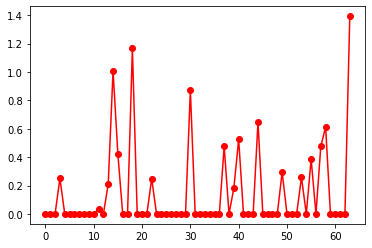

In [67]:
plt.plot(pool2_result[0,:], '-ro')

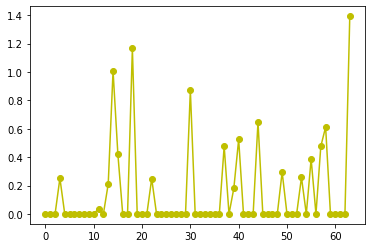

In [68]:
plt.plot(mcu_pool2[:], '-yo')

In [73]:
np.argmax(pool2_result[0,:])

6